02-cheater-analysis.ipynb
======================

The aim of this section is to analyse the characteristics of cheaters and those of non-cheaters.

* Calculate the average kill ratio of cheaters and that of non-cheaters.
* Calculate the average time difference between consecutive kills of cheaters and that of non-cheaters.
* Perform t-tests.

## Load packages and read tables.

In [16]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pubg_analysis as pubg

In this section, we compare cheaters and non-cheaters who played the game between March 1 and March 3.<br>
The number of cheaters who were banned during this period is 651.

In [2]:
# Read a table that contains edges.
PATH_TO_DATA = "s3://social-research-cheating/cheater-analysis/data_for_cheater_analysis.parquet"
td = spark.read.parquet(PATH_TO_DATA)
td.registerTempTable("td")

# Read a table that contains player data.
PATH_TO_PLAYER_DATA = "s3://social-research-cheating/players.parquet"
players = spark.read.parquet(PATH_TO_PLAYER_DATA)
players.registerTempTable("players")

# Create a table of cheaters who were banned between March 1 and March 3.
# The assumption is that cheaters who were banned during this period always did cheat.
cheaters = spark.sql("SELECT * FROM players WHERE ban_date <= '2019-03-03'")
cheaters.registerTempTable("cheaters")
print(cheaters.count())

651


In [3]:
# Show the first few rows in each dataset.
# td.show(5)
players.show(5)
cheaters.show(5)

+--------------------+----------+-------------+--------+
|                  id|     pname|cheating_flag|ban_date|
+--------------------+----------+-------------+--------+
|account.10166f813...|sinsoksa00|            0|      NA|
|account.53b636966...|  junmosex|            0|      NA|
|account.5431e43ad...| xogusWkd1|            0|      NA|
|account.1084bf6ff...|modric0327|            0|      NA|
|account.d217967df...|     D_ain|            0|      NA|
+--------------------+----------+-------------+--------+
only showing top 5 rows

+--------------------+---------------+-------------+----------+
|                  id|          pname|cheating_flag|  ban_date|
+--------------------+---------------+-------------+----------+
|account.bace85a16...|        AEDAN77|            1|2019-03-03|
|account.78f031198...|     immanuel10|            1|2019-03-03|
|account.a63c0c91d...|         HO_0_G|            1|2019-03-03|
|account.c9f57b769...|      ParkJiHae|            1|2019-03-03|
|account.90dd9

## Calculate the average kill ratio for each cheater.

The Mean of average kill ratio is 0.77 for cheaters and the median value is 0.82.

In [4]:
# Get a dataframe that stores kill records of cheaters.
c_kill_logs = spark.sql("""SELECT mid, src, time, m_date, ban_date 
                           FROM td t JOIN cheaters c ON t.src = c.id""")
c_kill_logs.registerTempTable("kill_logs")

# Get a dataframe that stores death records of cheaters.
c_death_logs = spark.sql("""SELECT mid, dst, time, m_date, ban_date 
                            FROM td t JOIN cheaters c ON t.dst = c.id""")
c_death_logs.registerTempTable("death_logs")

c_avg_kill_ratio = pubg.get_avg_kill_ratio(c_kill_logs, c_death_logs)

# Calculate the mean and median of average kill ratio.
print(round(c_avg_kill_ratio['avg_kill_ratio'].mean(), 4))
print(round(c_avg_kill_ratio['avg_kill_ratio'].median(), 4))

# Count the number of unique cheaters who have the information on the averge kill ratio.
print(len(c_avg_kill_ratio['avg_kill_ratio']))

c_avg_kill_ratio['avg_kill_ratio'] = c_avg_kill_ratio['avg_kill_ratio'].round(4)

0.7661
0.8235
651


In [7]:
# Convert a Pandas dataframe to a Spark dataframe and store it in the S3 bucket.
c_avg_kill_ratio_df = spark.createDataFrame(c_avg_kill_ratio)
c_avg_kill_ratio_df.show(10)

PATH_TO_PARQUET = "s3://social-research-cheating/cheater-analysis/c_avg_kill_ratio.parquet"
c_avg_kill_ratio_df.write.parquet(PATH_TO_PARQUET)

+--------------------+--------------+
|                  id|avg_kill_ratio|
+--------------------+--------------+
|account.002dced5b...|        0.8865|
|account.0087b5d4a...|        0.6923|
|account.00a68dddf...|        0.9205|
|account.010f30864...|        0.6667|
|account.012829a2f...|        0.8889|
|account.0198bd285...|         0.568|
|account.021034455...|           1.0|
|account.0230c074a...|        0.9146|
|account.028e1de9d...|        0.7771|
|account.036236700...|        0.3966|
+--------------------+--------------+
only showing top 10 rows



## Calculate the average kill ratio for each non-cheater.

The Mean of average kill ratio is 0.4 for non-cheaters and the median value is 0.44.<br>
The number of non-cheaters who played the game between March 1 and March 3 is 854,153.

In [8]:
# Create a dataframe that stores kill records of non-cheaters.
nc_kill_logs = spark.sql("""SELECT mid, src, dst, time, m_date 
                            FROM td t JOIN players p ON t.src = p.id WHERE cheating_flag = '0'""")
nc_kill_logs.registerTempTable("kill_logs")

# Create a dataframe that stores death counts of non-cheaters.
nc_death_logs = spark.sql("""SELECT mid, src, dst, time, m_date 
                             FROM td t JOIN players p ON t.dst = p.id WHERE cheating_flag = '0'""")
nc_death_logs.registerTempTable("death_logs")

nc_avg_kill_ratio = pubg.get_avg_kill_ratio(nc_kill_logs, nc_death_logs)

# Calculate the mean and median of average kill ratio.
print(round(nc_avg_kill_ratio['avg_kill_ratio'].mean(), 4))
print(round(nc_avg_kill_ratio['avg_kill_ratio'].median(), 4))

# Count the number of unique non-cheaters who have the information on the averge kill ratio.
print(len(nc_avg_kill_ratio['avg_kill_ratio']))

nc_avg_kill_ratio['avg_kill_ratio'] = nc_avg_kill_ratio['avg_kill_ratio'].round(4)

0.4045
0.4437
854153


In [9]:
# Convert a Pandas dataframe to a Spark dataframe and store it in the S3 bucket.
nc_avg_kill_ratio_df = spark.createDataFrame(nc_avg_kill_ratio)
nc_avg_kill_ratio_df.show(10)

PATH_TO_PARQUET = "s3://social-research-cheating/cheater-analysis/nc_avg_kill_ratio.parquet"
nc_avg_kill_ratio_df.write.parquet(PATH_TO_PARQUET)

+--------------------+--------------+
|                  id|avg_kill_ratio|
+--------------------+--------------+
|account.0000074ae...|        0.5675|
|account.000033c3d...|        0.5385|
|account.000046d1e...|           0.3|
|account.00006cfdb...|         0.875|
|account.000078418...|          0.25|
|account.00007c1e6...|           0.0|
|account.0000bd144...|        0.5152|
|account.0000c5a5c...|        0.5227|
|account.0000cd816...|        0.3585|
|account.0000f03a4...|           0.0|
+--------------------+--------------+
only showing top 10 rows



## Plot the histogram of average kill ratio for both cheaters and non-cheaters.

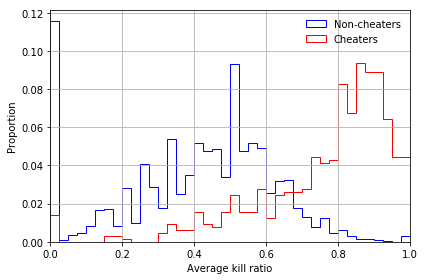

In [10]:
# Plot the histograms of cheaters and non-cheaters together.
ax = nc_avg_kill_ratio.hist(column='avg_kill_ratio', histtype='step', edgecolor='blue', bins=40, label='Non-cheaters', 
                            weights=np.zeros_like(nc_avg_kill_ratio['avg_kill_ratio'])+1./len(nc_avg_kill_ratio['avg_kill_ratio']))
fig = c_avg_kill_ratio.hist(column='avg_kill_ratio', histtype='step', edgecolor='red', bins=40, label='Cheaters', 
                            weights=np.zeros_like(c_avg_kill_ratio['avg_kill_ratio'])+1./len(c_avg_kill_ratio['avg_kill_ratio']), ax=ax)
plt.title('')
plt.xlim(xmin = 0)
plt.xlim(xmax = 1)
plt.xlabel('Average kill ratio')
plt.ylabel('Proportion')
plt.tight_layout()
plt.legend(loc='upper right', frameon=False)
image = plt.show()

## Calculate the average time difference between consecutive kills for each cheater.

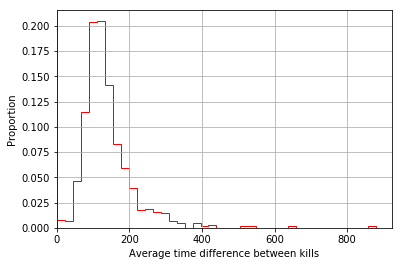

In [11]:
# Get a dataframe that stores kill records of cheaters.
c_kill_logs.registerTempTable("kill_logs")

c_avg_kill_interval = pubg.get_avg_time_diff_between_kills(c_kill_logs)

# Plot the distribution of the overall average time difference between kills.
fig = c_avg_kill_interval.hist(column='delta', histtype='step', edgecolor='red', bins=40, 
                               weights=np.zeros_like(c_avg_kill_interval['delta'])+1./len(c_avg_kill_interval['delta']))
plt.xlim(xmin = 0)
plt.xlabel("Average time difference between kills")
plt.ylabel("Proportion")
plt.title("")
image = plt.show()

In [13]:
# Calculate the mean and median of average time difference between kills.
print(round(c_avg_kill_interval['delta'].mean(), 4))
print(round(c_avg_kill_interval['delta'].median(), 4))

# Count the number of unique cheaters who have the information on the averge time difference between kills.
print(len(c_avg_kill_interval['delta']))

c_avg_kill_interval['delta'] = c_avg_kill_interval['delta'].round(4)

139.6698
123.9302
629


In [15]:
# Convert a Pandas dataframe to a Spark dataframe and store it in the S3 bucket.
c_avg_kill_interval_df = spark.createDataFrame(c_avg_kill_interval)
c_avg_kill_interval_df.show(10)

PATH_TO_PARQUET = "s3://social-research-cheating/cheater-analysis/c_avg_kill_interval.parquet"
c_avg_kill_interval_df.write.parquet(PATH_TO_PARQUET)

+--------------------+--------+
|                 src|   delta|
+--------------------+--------+
|account.ba9810e0f...|201.2667|
|account.61973e29f...|251.6154|
|account.8d69e3520...| 98.1818|
|account.dc0d711ba...|127.3571|
|account.feec603d5...| 60.3797|
|account.bcb700986...|184.1081|
|account.11dbd81ee...|101.2308|
|account.1c4cf8633...|301.8333|
|account.a98a65311...| 267.875|
|account.da1a6fa0b...|168.3611|
+--------------------+--------+
only showing top 10 rows



## Calculate the average time difference between consecutive kills for each non-cheater.

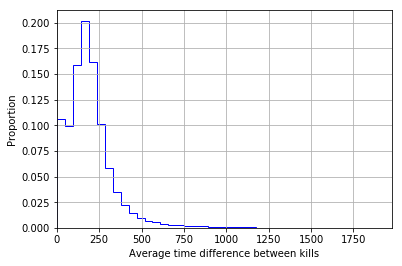

In [17]:
# Get a dataframe that stores kill records of non-cheaters.
nc_kill_logs.registerTempTable("kill_logs")

nc_avg_kill_interval = pubg.get_avg_time_diff_between_kills(nc_kill_logs)

# Plot the distribution of the overall average time difference between kills.
fig = nc_avg_kill_interval.hist(column='delta', histtype='step', edgecolor='blue', bins=40, 
                                weights=np.zeros_like(nc_avg_kill_interval['delta'])+1./len(nc_avg_kill_interval['delta']))
plt.xlim(xmin = 0)
plt.xlabel("Average time difference between kills")
plt.ylabel("Proportion")
plt.title("")
image = plt.show()

In [18]:
# Calculate the mean and median of average time difference between kills.
print(round(nc_avg_kill_interval['delta'].mean(), 4))
print(round(nc_avg_kill_interval['delta'].median(), 4))

# Count the number of unique non-cheaters who have the information on the averge time difference between kills.
print(len(nc_avg_kill_interval['delta']))

nc_avg_kill_interval['delta'] = nc_avg_kill_interval['delta'].round(4)

194.109
172.6348
623678


In [19]:
# Convert a Pandas dataframe to a Spark dataframe and store it in the S3 bucket.
nc_avg_kill_interval_df = spark.createDataFrame(nc_avg_kill_interval)
nc_avg_kill_interval_df.show(10)

PATH_TO_PARQUET = "s3://social-research-cheating/cheater-analysis/nc_avg_kill_interval.parquet"
nc_avg_kill_interval_df.write.parquet(PATH_TO_PARQUET)

+--------------------+--------+
|                 src|   delta|
+--------------------+--------+
|account.0017aeb1b...| 173.625|
|account.003114883...|   409.5|
|account.00399d4c2...|222.3333|
|account.003c16440...|324.5714|
|account.005593793...|   145.3|
|account.006364873...|166.8889|
|account.008c8793f...|320.0909|
|account.008f0f168...| 332.625|
|account.00aecc47c...| 62.3333|
|account.00af06e0a...|240.8462|
+--------------------+--------+
only showing top 10 rows



## Plot the histogram of average time difference between kills for both cheaters and non-cheaters.

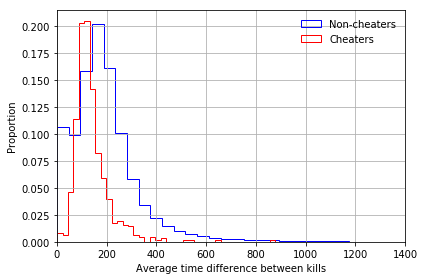

In [20]:
# Plot the histograms of cheaters and non-cheaters together.
ax = nc_avg_kill_interval.hist(column='delta', histtype='step', edgecolor='blue', bins=40, label='Non-cheaters', 
                               weights=np.zeros_like(nc_avg_kill_interval['delta'])+1./len(nc_avg_kill_interval['delta']))
fig = c_avg_kill_interval.hist(column='delta', histtype='step', edgecolor='red', bins=40, label='Cheaters', 
                               weights=np.zeros_like(c_avg_kill_interval['delta'])+1./len(c_avg_kill_interval['delta']), ax=ax)
plt.title('')
plt.xlabel('Average time difference between kills')
plt.ylabel('Proportion')
plt.xlim(xmin = 0)
plt.xlim(xmax=1400) # Exclude outliers.
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
image = plt.show()

## Perform t-tests.

The difference in the average kill ratio between the two groups is significant, t=48.64, p<0.01.
There is also a significant difference in the average time difference between consecutive kills, t=-18.24, p<0.01. 

In [21]:
import scipy
import scipy.stats
from scipy.stats import ttest_ind


print(scipy.stats.ttest_ind(c_avg_kill_ratio['avg_kill_ratio'], nc_avg_kill_ratio['avg_kill_ratio'], equal_var=False))
print(scipy.stats.ttest_ind(c_avg_kill_interval['delta'], nc_avg_kill_interval['delta'], equal_var=False))

Ttest_indResult(statistic=48.64290194985197, pvalue=5.213000260504692e-219)
Ttest_indResult(statistic=-18.235341545750604, pvalue=5.033833786064087e-60)
